In [66]:
! pip install pandas numpy scikit-learn

import pandas as pd
import numpy as np

## Load data

In [87]:
import pandas as pd
import numpy as np
BASE_DIR = "narpsdata/extended"
common_cols = [0, 1, 2]

def load_data(filename):
    df = pd.read_csv(filename, delimiter=" ", header=None)
    return df

def merge_and_fillna(reference_df, target_df):
    merged_df = pd.merge(reference_df, target_df, on=common_cols, how='left')
    merged_df = merged_df.fillna(0)
    return merged_df

def xyz(df):
    return set(zip(df[0].tolist(), df[1].tolist(), df[2].tolist()))

def clean_data(gain_range, loss_range, gain_indifference, loss_indifference):
    ind_xyz = xyz(gain_indifference)
    rng_xyz = xyz(gain_range)
    all_xyz = ind_xyz | rng_xyz
    all_coords = pd.DataFrame(list(all_xyz), columns=common_cols)
    
    new_gain_range = merge_and_fillna(all_coords, gain_range)
    new_loss_range = merge_and_fillna(all_coords, loss_range)
    new_gain_indifference = merge_and_fillna(all_coords, gain_indifference)
    new_loss_indifference = merge_and_fillna(all_coords, loss_indifference)
    return (new_gain_range, new_loss_range, new_gain_indifference, new_loss_indifference), all_xyz

def reset_data_frame(df):
    df = df.transpose() # row = subject
    df = df.drop(common_cols, axis='index') # drop rows with x,y,z
    df = df.reset_index(drop=True)
    return df

def load_all_data():
    gain_range = load_data(f"{BASE_DIR}/gain_range_vmpfc.csv")
    loss_range = load_data(f"{BASE_DIR}/loss_range_vmpfc.csv")
    gain_indifference = load_data(f"{BASE_DIR}/gain_ind_vmpfc.csv")
    loss_indifference = load_data(f"{BASE_DIR}/loss_ind_vmpfc.csv")
    
    (gain_range, loss_range, gain_indifference, loss_indifference), all_xyz = clean_data(gain_range, loss_range, gain_indifference, loss_indifference)

    gain_range = reset_data_frame(gain_range)
    loss_range = reset_data_frame(loss_range)
    gain_indifference = reset_data_frame(gain_indifference)
    loss_indifference = reset_data_frame(loss_indifference)

    gain_range["gain_or_loss"] = 1
    loss_range["gain_or_loss"] = 0
    gain_indifference["gain_or_loss"] = 1
    loss_indifference["gain_or_loss"] = 0
    
    df = pd.concat([gain_range, loss_range, gain_indifference, loss_indifference]).reset_index(drop=True)
    X = df.drop("gain_or_loss", axis='columns').fillna(0).to_numpy()
    y = df["gain_or_loss"].to_numpy()
    return X, y, all_xyz


In [88]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [89]:
X, y, all_xyz = load_all_data()

In [70]:
X.shape

(202, 3773)

In [71]:
X.shape

(202, 3773)

## Prepare training and test data

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [73]:
(X_train.shape, y_train.shape)

((161, 3773), (161,))

In [74]:
(X_test.shape, y_test.shape)

((41, 3773), (41,))

## Gridsearch

In [75]:
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()

def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.55, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.55

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [76]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report

def search(base_model, params, n_iter=500):
    scores = ["precision", "recall", "accuracy"]
    grid_search = RandomizedSearchCV(base_model, params, scoring=scores, refit=refit_strategy, n_iter=n_iter)
    grid_search.fit(X_train, y_train)

    print("Best params:", grid_search.best_params_)
    preds = grid_search.predict(X_test)
    print(classification_report(y_test, preds))

    return grid_search


## Linear

In [77]:
from sklearn.utils.fixes import loguniform

tuned_parameters = [
    {'C': loguniform(1e-2, 1e3), 'gamma': loguniform(1e-4, 1e-3), 'kernel': ['rbf']},
    {'C': loguniform(1e-2, 1e3), 'kernel': ['linear']}
]

search(SVC(), tuned_parameters)

/Users/arkadiusz.wolk/miniforge3/envs/mro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arkadiusz.wolk/miniforge3/envs/mro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arkadiusz.wolk/miniforge3/envs/mro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/arkadiusz.wolk/miniforge3/e

All grid-search results:
precision: 0.656 (±0.082), recall: 0.591 (±0.127), for {'C': 0.15737467582642617, 'kernel': 'linear'}
precision: 0.656 (±0.082), recall: 0.591 (±0.127), for {'C': 0.010223802535785571, 'kernel': 'linear'}
precision: 0.656 (±0.082), recall: 0.591 (±0.127), for {'C': 0.07366841633577037, 'kernel': 'linear'}
precision: 0.656 (±0.082), recall: 0.591 (±0.127), for {'C': 23.459433129949744, 'kernel': 'linear'}
precision: 0.656 (±0.082), recall: 0.591 (±0.127), for {'C': 0.15743277004342143, 'kernel': 'linear'}
precision: 0.656 (±0.082), recall: 0.591 (±0.127), for {'C': 0.03569776617138083, 'kernel': 'linear'}
precision: 0.000 (±0.000), recall: 0.000 (±0.000), for {'C': 0.023932472730361788, 'gamma': 0.00010048679696796432, 'kernel': 'rbf'}
precision: 0.670 (±0.103), recall: 0.564 (±0.174), for {'C': 299.32866599911324, 'gamma': 0.0005854568168786769, 'kernel': 'rbf'}
precision: 0.656 (±0.082), recall: 0.591 (±0.127), for {'C': 2.9765567173741436, 'kernel': 'linear'}

RandomizedSearchCV(estimator=SVC(), n_iter=500,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x169070910>,
                                         'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1690735e0>,
                                         'kernel': ['rbf']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1690737c0>,
                                         'kernel': ['linear']}],
                   refit=<function refit_strategy at 0x166bc2710>,
                   scoring=['precision', 'recall', 'accuracy'])

## Random Forest

In [78]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

tuned_parameters = [
    {'n_estimators': randint(1, 1000), 'max_depth': randint(1, 20)}
]

search(RandomForestClassifier(), tuned_parameters, n_iter=100)

All grid-search results:
precision: 0.682 (±0.117), recall: 0.590 (±0.092), for {'max_depth': 4, 'n_estimators': 817}
precision: 0.644 (±0.125), recall: 0.526 (±0.074), for {'max_depth': 9, 'n_estimators': 904}
precision: 0.661 (±0.124), recall: 0.502 (±0.061), for {'max_depth': 1, 'n_estimators': 187}
precision: 0.614 (±0.035), recall: 0.501 (±0.155), for {'max_depth': 17, 'n_estimators': 40}
precision: 0.583 (±0.091), recall: 0.576 (±0.059), for {'max_depth': 7, 'n_estimators': 99}
precision: 0.633 (±0.051), recall: 0.552 (±0.127), for {'max_depth': 16, 'n_estimators': 367}
precision: 0.655 (±0.133), recall: 0.526 (±0.074), for {'max_depth': 19, 'n_estimators': 805}
precision: 0.685 (±0.123), recall: 0.538 (±0.122), for {'max_depth': 2, 'n_estimators': 473}
precision: 0.698 (±0.119), recall: 0.539 (±0.131), for {'max_depth': 12, 'n_estimators': 92}
precision: 0.590 (±0.076), recall: 0.476 (±0.128), for {'max_depth': 17, 'n_estimators': 14}
precision: 0.632 (±0.080), recall: 0.514 (±0

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions=[{'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1690734f0>,
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x169073a90>}],
                   refit=<function refit_strategy at 0x166bc2710>,
                   scoring=['precision', 'recall', 'accuracy'])

## Neural Network

In [82]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(200, 100, 50, 20), random_state=42, verbose=False)
model.fit(X_train, y_train)

preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.54      0.78      0.64        18
           1       0.73      0.48      0.58        23

    accuracy                           0.61        41
   macro avg       0.64      0.63      0.61        41
weighted avg       0.65      0.61      0.60        41



In [130]:
import matplotlib.pyplot as plt

def plot_filter(model, filter_idx):
    filters = model.coefs_[0]
    selected_filter = filters[:, filter_idx]

    max_x, max_y, max_z = max(all_xyz, key=lambda v: v[0])[0], max(all_xyz, key=lambda v: v[1])[1], max(all_xyz, key=lambda v: v[2])[2]
    min_x, min_y, min_z = min(all_xyz, key=lambda v: v[0])[0], min(all_xyz, key=lambda v: v[1])[1], min(all_xyz, key=lambda v: v[2])[2]
    grid_selected_filter = np.zeros((max_x-min_x+1, max_y-min_y+1, max_z-min_z+1))

    for (x,y,z),v in zip(list(all_xyz), selected_filter.tolist()):
        grid_selected_filter[x-min_x, y-min_y, z-min_z] = v

    for i in range(0, max_z-min_z+1):
        plt.imshow(grid_selected_filter[:, :, i], cmap='gray', vmin=selected_filter.min(), vmax=selected_filter.max())
        plt.show()

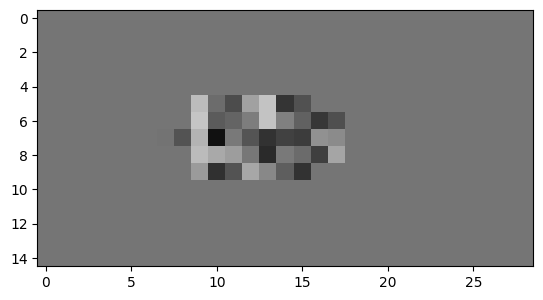

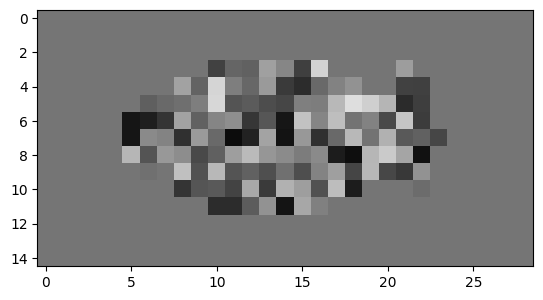

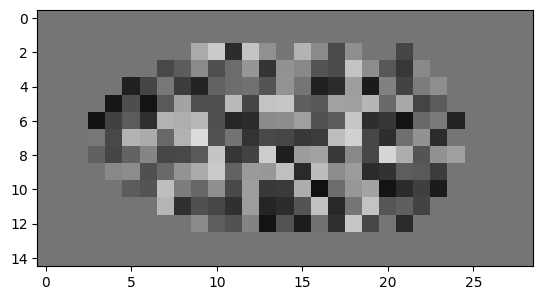

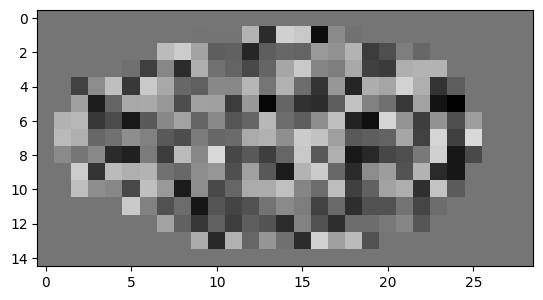

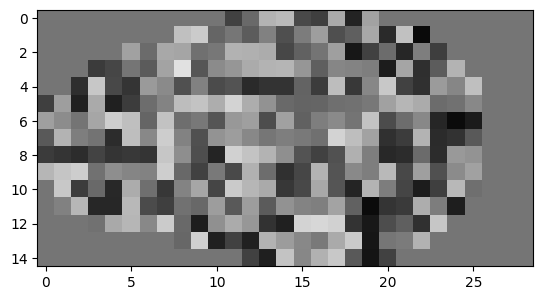

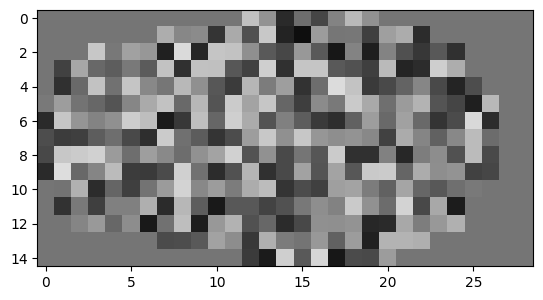

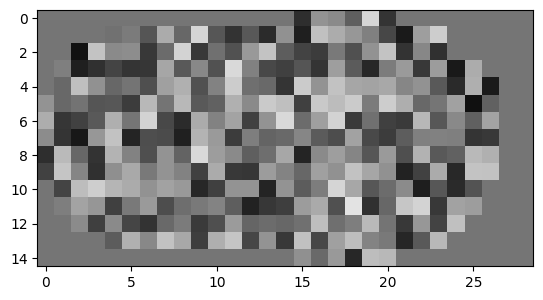

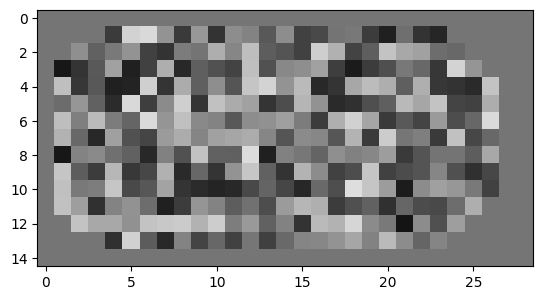

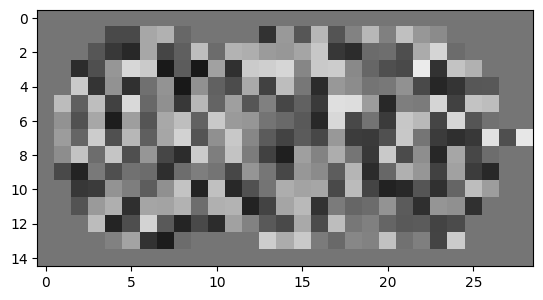

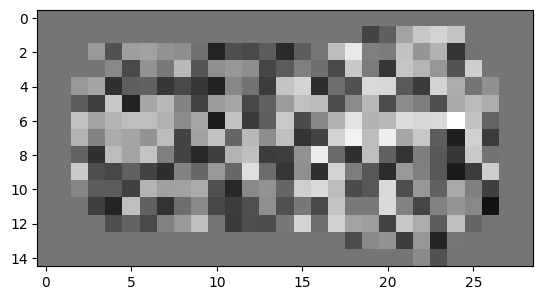

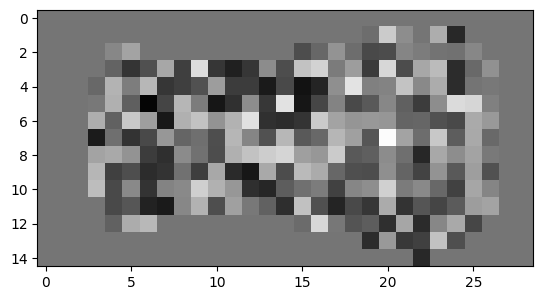

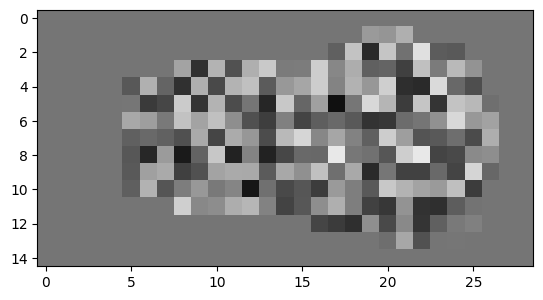

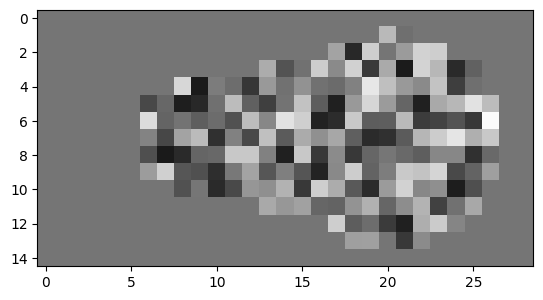

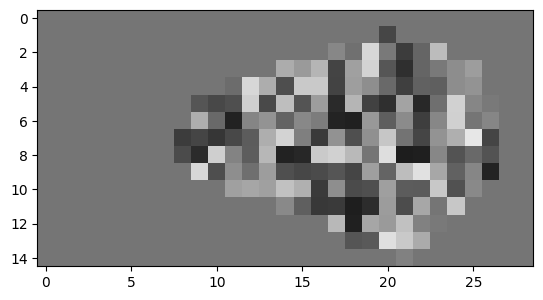

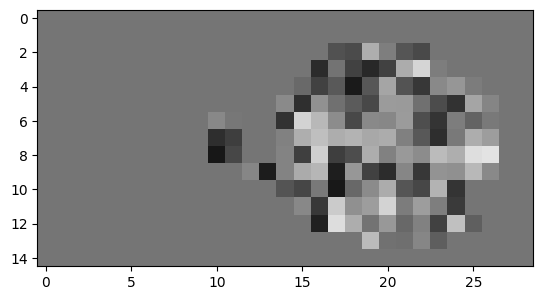

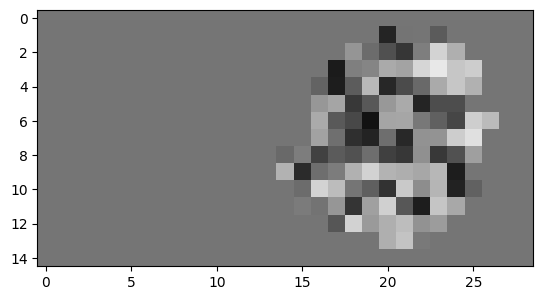

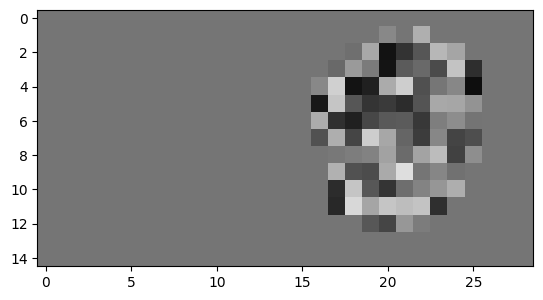

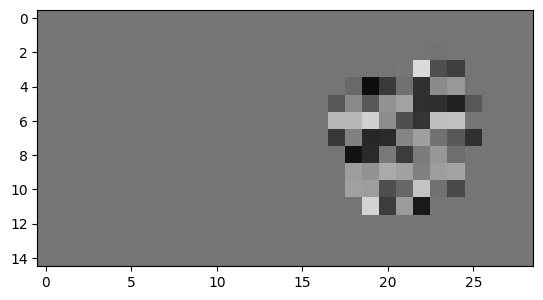

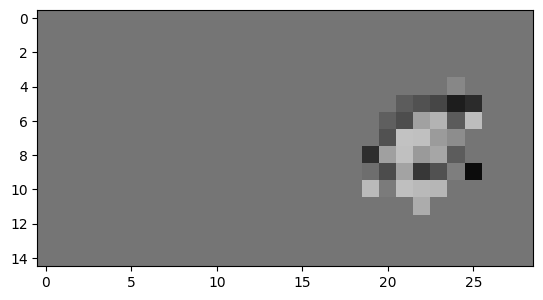

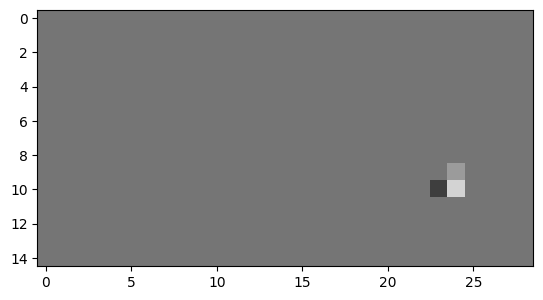

In [131]:
plot_filter(model, 20)